# What is my task?

Mr Cj need's an application which can predict food in application, after prediction the application will have it's own logic to calculate calories ... i have to create the model which predict food.

# What is our data?

We will use [this dataset](https://huggingface.co/datasets/ethz/food101) from hugging face.

This dataset consists of **101 food categories**, with **101'000 images**. For each class, **250 manually reviewed test images** are provided as well as **750 training images**.

On purpose, the training images were **not cleaned**, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side **length of 512 pixels**.

A sample from the training set is provided below:
```json
{
  "image": "<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x512 at 0x276021C5EB8>",
  "label": "23"
}
```

Labels are encoded as below:
```json
{
  "apple_pie": 0,
  "baby_back_ribs": 1,
  "baklava": 2,
  "beef_carpaccio": 3,
  "beef_tartare": 4,
  "beet_salad": 5,
  "beignets": 6,
  "bibimbap": 7,
  "bread_pudding": 8,
  "breakfast_burrito": 9,
  "bruschetta": 10,
  "caesar_salad": 11,
  "cannoli": 12,
  "caprese_salad": 13,
  "carrot_cake": 14,
  "ceviche": 15,
  "cheesecake": 16,
  "cheese_plate": 17,
  "chicken_curry": 18,
  "chicken_quesadilla": 19,
  "chicken_wings": 20,
  "chocolate_cake": 21,
  "chocolate_mousse": 22,
  "churros": 23,
  "clam_chowder": 24,
  "club_sandwich": 25,
  "crab_cakes": 26,
  "creme_brulee": 27,
  "croque_madame": 28,
  "cup_cakes": 29,
  "deviled_eggs": 30,
  "donuts": 31,
  "dumplings": 32,
  "edamame": 33,
  "eggs_benedict": 34,
  "escargots": 35,
  "falafel": 36,
  "filet_mignon": 37,
  "fish_and_chips": 38,
  "foie_gras": 39,
  "french_fries": 40,
  "french_onion_soup": 41,
  "french_toast": 42,
  "fried_calamari": 43,
  "fried_rice": 44,
  "frozen_yogurt": 45,
  "garlic_bread": 46,
  "gnocchi": 47,
  "greek_salad": 48,
  "grilled_cheese_sandwich": 49,
  "grilled_salmon": 50,
  "guacamole": 51,
  "gyoza": 52,
  "hamburger": 53,
  "hot_and_sour_soup": 54,
  "hot_dog": 55,
  "huevos_rancheros": 56,
  "hummus": 57,
  "ice_cream": 58,
  "lasagna": 59,
  "lobster_bisque": 60,
  "lobster_roll_sandwich": 61,
  "macaroni_and_cheese": 62,
  "macarons": 63,
  "miso_soup": 64,
  "mussels": 65,
  "nachos": 66,
  "omelette": 67,
  "onion_rings": 68,
  "oysters": 69,
  "pad_thai": 70,
  "paella": 71,
  "pancakes": 72,
  "panna_cotta": 73,
  "peking_duck": 74,
  "pho": 75,
  "pizza": 76,
  "pork_chop": 77,
  "poutine": 78,
  "prime_rib": 79,
  "pulled_pork_sandwich": 80,
  "ramen": 81,
  "ravioli": 82,
  "red_velvet_cake": 83,
  "risotto": 84,
  "samosa": 85,
  "sashimi": 86,
  "scallops": 87,
  "seaweed_salad": 88,
  "shrimp_and_grits": 89,
  "spaghetti_bolognese": 90,
  "spaghetti_carbonara": 91,
  "spring_rolls": 92,
  "steak": 93,
  "strawberry_shortcake": 94,
  "sushi": 95,
  "tacos": 96,
  "takoyaki": 97,
  "tiramisu": 98,
  "tuna_tartare": 99,
  "waffles": 100
}

```

# What is my plan?

Im going to create a model with architecture VERYYYYY similare to `tiny VGG`. I will also use transfer learning too.

# Hands On CODE!!

## Import needed libraries

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from pathlib import Path
import gradio as gr
from PIL import Image

### Setup some constants

In [25]:
RANDOM_SEED = 42
IMAGE_SIZE = 224
BATCH_SIZE = 32
MAX_EPOCHS = 5
CHECK_POINT_PATH = Path("./check-points")
CHECK_POINT_PATH.mkdir(exist_ok=True)
MODELS_PATH = Path("./models")
MODELS_PATH.mkdir(exist_ok=True)


## Dataset part

### Download dataset from tensorflow dataset

In [ ]:
(train_ds, test_ds), dsInfo = tfds.load(
    name="food101",
    split=["train", "validation"],
    shuffle_files=True,
    as_supervised=True, # download dataset as tuple of (sample, label), in our case it is (image, label)
    with_info=True, # don't forget to give me an info about dataset
)


### Understand dataset

In [ ]:
dsInfo

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir='/root/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    split

This object contains our labels, Let's print some of it:

In [ ]:
print("10 first labels: ")
for idx, name in enumerate(dsInfo.features["label"].names):
  print(f"\t{name}: {idx}, ")
  if idx == 10:
    break

10 first labels: 
	apple_pie: 0, 
	baby_back_ribs: 1, 
	baklava: 2, 
	beef_carpaccio: 3, 
	beef_tartare: 4, 
	beet_salad: 5, 
	beignets: 6, 
	bibimbap: 7, 
	bread_pudding: 8, 
	breakfast_burrito: 9, 
	bruschetta: 10, 


Good now let's get take some samples:

In [ ]:
train_samples = train_ds.take(3)

In [ ]:
train_samples

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
for image, label in train_samples:
  print(f"image shape: {image.shape}")
  print(f"image dtype: {image.dtype}")
  print(f"image class: {label}")
  print("-" * 30)

image shape: (512, 512, 3)
image dtype: <dtype: 'uint8'>
image class: 18
------------------------------
image shape: (512, 512, 3)
image dtype: <dtype: 'uint8'>
image class: 97
------------------------------
image shape: (512, 512, 3)
image dtype: <dtype: 'uint8'>
image class: 69
------------------------------


Now let's plot samples:

<Figure size 1500x500 with 0 Axes>

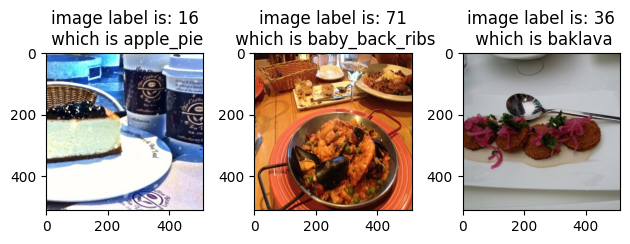

In [ ]:
plt.figure(figsize=(15, 5))
fig, axes = plt.subplots(ncols=len(train_samples))

for idx, (image, label) in enumerate(train_samples):
  axes[idx].imshow(image)
  axes[idx].set_title(f"image label is: {label}\n which is {dsInfo.features["label"].names[idx]}")

plt.tight_layout()
plt.show()

## Preprocess

In [ ]:
def preprocess(img, label):
  image = tf.image.resize(img , (IMAGE_SIZE, IMAGE_SIZE))
  return tf.cast(image, tf.float32), label

This function takes image and label and:
1. it'll resize image (we want 255)
2. it'll turn image pixels into a value between 0 and 1

Now let's map it on dataset ...

In [ ]:
train_ds = train_ds.map(
    map_func=preprocess,
    num_parallel_calls=tf.data.AUTOTUNE
).shuffle(
    buffer_size=1000
).batch(
    BATCH_SIZE
).prefetch(
    buffer_size=tf.data.AUTOTUNE
)

test_ds = test_ds.map(
    map_func=preprocess,
    num_parallel_calls=tf.data.AUTOTUNE
).batch(
    BATCH_SIZE
).prefetch(
    buffer_size=tf.data.AUTOTUNE
)

In [ ]:
train_ds, test_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

Wll done, we did our preprocess step

## Performance Step

In [ ]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

If our gpu compute capability is 7.0+ then we can use `mixed precision` feature which help model to learn faster. because it uses `float32` and `float16` at same time. Cool? [READMORE](https://www.tensorflow.org/guide/mixed_precision).

Now if it set correctly with no problem, in line below you shall see *<DTypePolicy "mixed_float16">*.

In [ ]:
tf.keras.mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## My Model

### Setup block generator

In [ ]:
def generate_block(inp_tensor, filter_count):
  x = tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=filter_count, padding="same")(inp_tensor)
  x = tf.keras.layers.PReLU()(x)
  return x

### Setup model architecture

In [ ]:
repeatBlock = 1
addAfterEachIter = 0

input = tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

X = tf.keras.layers.Rescaling(1./255)(input)
X = tf.keras.layers.Conv2D(kernel_size=(5, 5), filters=16)(X)
X = tf.keras.layers.PReLU()(X)
X = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(X)

X = tf.keras.layers.Normalization()(X)

# stage 1: 32 channels Convolutions
for i in range(repeatBlock):
  X = generate_block(X, 32)
repeatBlock += addAfterEachIter

# stage 2: 64 channels Convolutions
for i in range(repeatBlock):
  X = generate_block(X, 64)
repeatBlock += addAfterEachIter

X = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(X)

# stage 3: 128 channels Convolutions
for i in range(repeatBlock):
  X = generate_block(X, 128)
repeatBlock -= addAfterEachIter

X = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(X)

# stage 3: 256 channels Convolutions
for i in range(repeatBlock):
  X = generate_block(X, 256)
repeatBlock += addAfterEachIter


In [ ]:
X = tf.keras.layers.GlobalAvgPool2D()(X)
X = tf.keras.layers.Dense(units=101, activation="softmax")(X)

model = tf.keras.Model(inputs=input, outputs=X)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 220, 220, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_9 (PReLU)               │ (None, 220, 220, 16)   │       774,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 110, 110, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_4 (Normalization) │ (None, 110, 110, 16)   │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 110, 110, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_10 (PReLU)              │ (None, 110, 110, 32)   │       387,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 110, 110, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_11 (PReLU)              │ (None, 110, 110, 64)   │       774,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 55, 55, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 55, 55, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_12 (PReLU)              │ (None, 55, 55, 128)    │       387,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 27, 27, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 27, 27, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_13 (PReLU)              │ (None, 27, 27, 256)    │       186,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,929,190 (11.17 MB)

 Trainable params: 2,929,157 (11.17 MB)

 Non-trainable params: 33 (136.00 B)

### Setup callbacks

In [ ]:
my_model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    (CHECK_POINT_PATH / "myModel-weights.weights.h5"), # i want to save weights so i use `weights.h5` ext
    monitor="val_loss",
    save_best_only= True,
    save_weights_only=True,
    verbose=0,
)

my_model_earlyStop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3
)

### Compile and fit

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=optim,
    metrics=["sparse_categorical_accuracy"]
)

In [ ]:
hist = model.fit(
    x=train_ds,
    validation_data=test_ds,
    epochs=100,
    callbacks=[
        my_model_checkpoint_cb,
        my_model_earlyStop_cb
    ],
)

NameError: name 'train_ds' is not defined

### Save model

In [ ]:
model.save((MODELS_PATH / "my_food_model.keras"))

In [ ]:
loaded_model = tf.keras.models.load_model((MODELS_PATH / "my_food_model.keras"))

## EfficientNetB0

I was looking into [keras.applications](https://keras.io/api/applications) for finding a good model, first i chose `EfficientNetB1` But it takes long to lrarn so now i want to use smaller one which is `EfficientNetB0`. If takes long again then i'll use `MobileNetV2`.

### Download EfficientNetB0

In [ ]:
effnetB0 = tf.keras.applications.EfficientNetB0(
    include_top=False, # i dont' need models top
    weights="imagenet",
    input_shape= (256, 256, 3),
    classes=101 # we have 101 classes for predict
)

effnetB0.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 256, 256,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 256, 256,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 256, 256,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 4,007,548 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

### Setup Architecture

In [ ]:
effnetB0.trainable = False # base model layers shall freeze

input = tf.keras.layers.Input(shape=(256, 256, 3))
X = effnetB0(inputs=input, training=False) # base model should not be trainable
X = tf.keras.layers.GlobalAveragePooling2D()(X)
X = tf.keras.layers.Dense(units=101, activation="softmax")(X)

effnetB0_model = tf.keras.Model(inputs=input, outputs=X)
effnetB0_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Setup callbacks

In [ ]:
model_effnetB0_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    (CHECK_POINT_PATH / "effnetB0-weights.weights.h5"), # i want to save weights so i use `h5` extension
    monitor="val_loss",
    save_best_only= True,
    save_weights_only=True,
    verbose=0,
)

model_effnetB0_earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3
)

### Compile and fit!

In [ ]:
effnetB0_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy', # sparse categorical crossentropy used when our labels are not one-hoted
    metrics=['accuracy']
)

effnetB0_hist = effnetB0_model.fit(
    x=train_ds,
    validation_data=test_ds,
    steps_per_epoch=len(train_ds),
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        model_effnetB0_checkpoint_cb,
        model_effnetB0_earlystop_cb
    ]
)

Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 350s 130ms/step - accuracy: 0.4784 - loss: 2.2999 - val_accuracy: 0.7082 - val_loss: 1.1094
Epoch 2/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 301s 125ms/step - accuracy: 0.6723 - loss: 1.2642 - val_accuracy: 0.7324 - val_loss: 0.9970
Epoch 3/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 277s 106ms/step - accuracy: 0.7084 - loss: 1.1172 - val_accuracy: 0.7372 - val_loss: 0.9606
Epoch 4/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 245s 102ms/step - accuracy: 0.7349 - loss: 1.0093 - val_accuracy: 0.7458 - val_loss: 0.9342
Epoch 5/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 293s 123ms/step - accuracy: 0.7471 - loss: 0.9515 - val_accuracy: 0.7482 - val_loss: 0.9174


### Evaluate this model

In [ ]:
effnetB0_model.evaluate(test_ds)

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.7443 - loss: 0.9199


[0.9173686504364014, 0.7481980323791504]

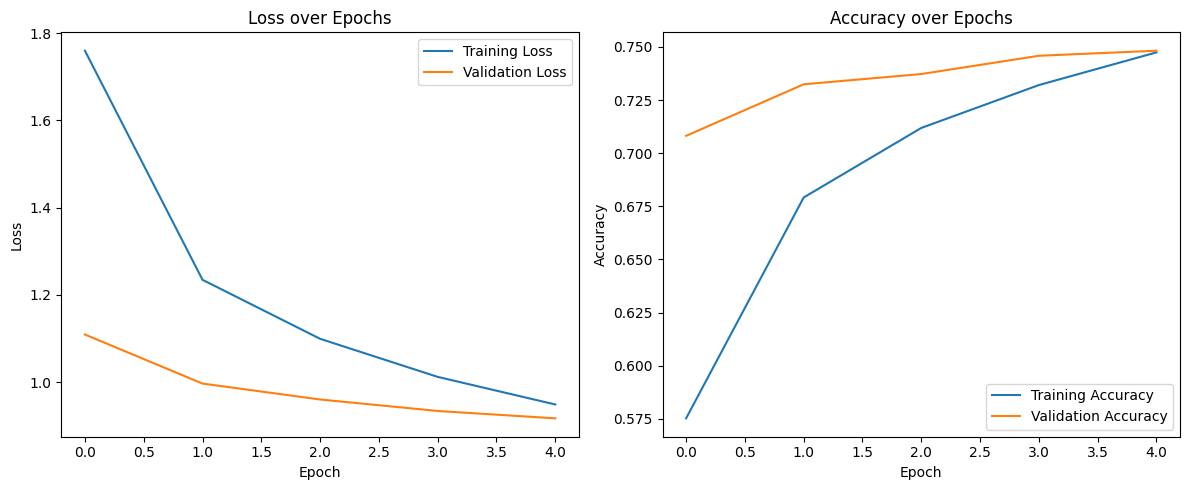

In [ ]:
history = effnetB0_hist.history

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

I like this Plot! let's move into predicts ...

**Note** When i was loading dataset i used `shuffle_files=True` which will shuffel validation dataset and this will make challenge for evaluating, i'll fetch dataset again.

In [ ]:
aligned_y_true = []
aligned_y_preds_probs = []

### --------------
# Reload test dataset
_, (val_ds_original) = tfds.load(
    name="food101",
    split=["train", "validation"],
    shuffle_files=False, # No need to shuffle for evaluation
    as_supervised=True,
    with_info=False, # Don't need info here
)

# Apply preprocessing and batching to the fresh validation dataset
fresh_test_ds = val_ds_original.map(
    map_func=preprocess,
    num_parallel_calls=tf.data.AUTOTUNE
).batch(
    BATCH_SIZE
).prefetch(
    buffer_size=tf.data.AUTOTUNE
)
### --------------

# Iterate over the fresh_test_ds ONCE to get both true labels and model predictions
for images_batch, labels_batch in fresh_test_ds:
    aligned_y_true.append(labels_batch.numpy())
    aligned_y_preds_probs.append(effnetB0_model.predict_on_batch(images_batch))

# Convert lists to numpy arrays
y_true = np.concatenate(aligned_y_true)
y_preds = np.concatenate(aligned_y_preds_probs) # 'y_preds' will now hold the probability distributions

print("Shape of y_true:", y_true.shape)
print("Shape of y_preds (probabilities):", y_preds.shape)
y_preds

Shape of y_true: (25250,)
Shape of y_preds (probabilities): (25250, 101)


array([[3.393e-03, 1.550e-06, 1.073e-05, ..., 2.684e-03, 4.735e-04,
        2.313e-01],
       [6.467e-05, 1.502e-05, 3.481e-04, ..., 3.922e-05, 8.354e-04,
        1.305e-05],
       [5.960e-06, 6.795e-06, 3.517e-06, ..., 4.172e-07, 1.794e-05,
        6.557e-07],
       ...,
       [1.056e-01, 1.494e-04, 1.490e-06, ..., 1.565e-04, 5.236e-04,
        1.132e-02],
       [2.205e-06, 0.000e+00, 1.788e-07, ..., 0.000e+00, 0.000e+00,
        2.384e-07],
       [1.094e-03, 3.123e-05, 1.573e-03, ..., 3.751e-02, 9.632e-05,
        3.684e-05]], dtype=float16)

In [ ]:
y_preds_max = np.argmax(y_preds, axis=1)

In [ ]:
# The 'y_true' variable has been populated in the previous cell (WbmZR1TLie1H)
# by iterating the test_ds alongside predictions to ensure correct alignment.
print("Shape of y_true:", y_true.shape)
y_true

Shape of y_true: (25250,)


array([29, 81, 91, ..., 76, 31, 21])

In [ ]:
print(classification_report(y_true, y_preds_max))

              precision    recall  f1-score   support

           0       0.61      0.48      0.53       250
           1       0.79      0.73      0.76       250
           2       0.75      0.79      0.77       250
           3       0.88      0.68      0.77       250
           4       0.66      0.62      0.64       250
           5       0.51      0.76      0.61       250
           6       0.84      0.82      0.83       250
           7       0.90      0.89      0.89       250
           8       0.58      0.59      0.59       250
           9       0.78      0.63      0.70       250
          10       0.69      0.64      0.66       250
          11       0.72      0.83      0.77       250
          12       0.80      0.77      0.78       250
          13       0.74      0.72      0.73       250
          14       0.83      0.67      0.74       250
          15       0.67      0.53      0.59       250
          16       0.60      0.58      0.59       250
          17       0.77    

### Save and load model

In [ ]:
effnetB0_model.save((MODELS_PATH / "effnetB0_food_model.keras"))

In [37]:
effnetB0_model = tf.keras.models.load_model((MODELS_PATH / "effnetB0_food_model.keras"))

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
